In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'silu',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

silu_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:30 - loss: 0.1015 - STD: 0.0063 - MAE: 0.3039

 4/74 [>.............................] - ETA: 1s - loss: 0.0430 - STD: 0.0079 - MAE: 0.1714  

 7/74 [=>............................] - ETA: 1s - loss: 0.0287 - STD: 0.0102 - MAE: 0.1294

10/74 [===>..........................] - ETA: 1s - loss: 0.0228 - STD: 0.0115 - MAE: 0.1137

13/74 [====>.........................] - ETA: 1s - loss: 0.0195 - STD: 0.0135 - MAE: 0.1038

17/74 [=====>........................] - ETA: 1s - loss: 0.0168 - STD: 0.0167 - MAE: 0.0960

21/74 [=======>......................] - ETA: 0s - loss: 0.0151 - STD: 0.0206 - MAE: 0.0908

24/74 [========>.....................] - ETA: 0s - loss: 0.0141 - STD: 0.0235 - MAE: 0.0879

27/74 [=========>....................] - ETA: 0s - loss: 0.0133 - STD: 0.0260 - MAE: 0.0853

30/74 [===========>..................] - ETA: 0s - loss: 0.0126 - STD: 0.0281 - MAE: 0.0831

33/74 [============>.................] - ETA: 0s - loss: 0.0121 - STD: 0.0298 - MAE: 0.0812

36/74 [=============>................] - ETA: 0s - loss: 0.0116 - STD: 0.0314 - MAE: 0.0797

39/74 [==============>...............] - ETA: 0s - loss: 0.0112 - STD: 0.0331 - MAE: 0.0783

42/74 [================>.............] - ETA: 0s - loss: 0.0109 - STD: 0.0346 - MAE: 0.0771

45/74 [=================>............] - ETA: 0s - loss: 0.0105 - STD: 0.0359 - MAE: 0.0759

48/74 [==================>...........] - ETA: 0s - loss: 0.0103 - STD: 0.0370 - MAE: 0.0749

51/74 [===================>..........] - ETA: 0s - loss: 0.0100 - STD: 0.0381 - MAE: 0.0740

54/74 [====================>.........] - ETA: 0s - loss: 0.0098 - STD: 0.0389 - MAE: 0.0733

57/74 [======================>.......] - ETA: 0s - loss: 0.0096 - STD: 0.0397 - MAE: 0.0725

61/74 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.0405 - MAE: 0.0716

65/74 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0416 - MAE: 0.0707

68/74 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0425 - MAE: 0.0701

71/74 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0429 - MAE: 0.0705

74/74 [==============================] - 4s 34ms/step - loss: 0.0091 - STD: 0.0426 - MAE: 0.0710 - val_loss: 0.0065 - val_STD: 0.0151 - val_MAE: 0.0617


Epoch 2/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0073 - STD: 0.0213 - MAE: 0.0667

 4/74 [>.............................] - ETA: 1s - loss: 0.0085 - STD: 0.0195 - MAE: 0.0683

 7/74 [=>............................] - ETA: 1s - loss: 0.0081 - STD: 0.0227 - MAE: 0.0699

10/74 [===>..........................] - ETA: 1s - loss: 0.0078 - STD: 0.0267 - MAE: 0.0678

13/74 [====>.........................] - ETA: 1s - loss: 0.0076 - STD: 0.0320 - MAE: 0.0671

16/74 [=====>........................] - ETA: 1s - loss: 0.0073 - STD: 0.0365 - MAE: 0.0661

19/74 [======>.......................] - ETA: 1s - loss: 0.0071 - STD: 0.0391 - MAE: 0.0648

22/74 [=======>......................] - ETA: 0s - loss: 0.0070 - STD: 0.0415 - MAE: 0.0643

25/74 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0430 - MAE: 0.0634

28/74 [==========>...................] - ETA: 0s - loss: 0.0067 - STD: 0.0446 - MAE: 0.0627

31/74 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0462 - MAE: 0.0621

34/74 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0478 - MAE: 0.0616

37/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0490 - MAE: 0.0611

40/74 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0499 - MAE: 0.0606

43/74 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0506 - MAE: 0.0602

46/74 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0513 - MAE: 0.0599

49/74 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0520 - MAE: 0.0595

52/74 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0527 - MAE: 0.0592

55/74 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0533 - MAE: 0.0589

59/74 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0541 - MAE: 0.0586

62/74 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0545 - MAE: 0.0586

65/74 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0545 - MAE: 0.0585

68/74 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0545 - MAE: 0.0584

71/74 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0545 - MAE: 0.0584

74/74 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0546 - MAE: 0.0584

74/74 [==============================] - 2s 21ms/step - loss: 0.0058 - STD: 0.0546 - MAE: 0.0584 - val_loss: 0.0044 - val_STD: 0.0417 - val_MAE: 0.0492


Epoch 3/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0053 - STD: 0.0574 - MAE: 0.0545

 4/74 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0558

 7/74 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0554

10/74 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0620 - MAE: 0.0549

13/74 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0621 - MAE: 0.0548

16/74 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0623 - MAE: 0.0547

19/74 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0626 - MAE: 0.0546

22/74 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0630 - MAE: 0.0544

25/74 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0543

28/74 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0542

31/74 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0638 - MAE: 0.0542

34/74 [============>.................] - ETA: 0s - loss: 0.0050 - STD: 0.0637 - MAE: 0.0542

37/74 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0637 - MAE: 0.0541

40/74 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0542

43/74 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0546

46/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0624 - MAE: 0.0549

49/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0613 - MAE: 0.0554

52/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0603 - MAE: 0.0557

55/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0596 - MAE: 0.0557

58/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0598 - MAE: 0.0558

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0600 - MAE: 0.0557

65/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0604 - MAE: 0.0557

68/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0605 - MAE: 0.0556

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0606 - MAE: 0.0555

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0606 - MAE: 0.0555

74/74 [==============================] - 2s 21ms/step - loss: 0.0053 - STD: 0.0606 - MAE: 0.0555 - val_loss: 0.0040 - val_STD: 0.0491 - val_MAE: 0.0481


Epoch 4/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0658 - MAE: 0.0537

 4/74 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0667 - MAE: 0.0533

 7/74 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0531

10/74 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0679 - MAE: 0.0529

13/74 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0675 - MAE: 0.0529

16/74 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0669 - MAE: 0.0528

19/74 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0664 - MAE: 0.0528

22/74 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0662 - MAE: 0.0527

25/74 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0664 - MAE: 0.0527

28/74 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0666 - MAE: 0.0525

31/74 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0666 - MAE: 0.0525

34/74 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0664 - MAE: 0.0525

37/74 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0663 - MAE: 0.0525

40/74 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0662 - MAE: 0.0525

43/74 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0662 - MAE: 0.0525

46/74 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0664 - MAE: 0.0525

49/74 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0664 - MAE: 0.0525

52/74 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0664 - MAE: 0.0524

55/74 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0664 - MAE: 0.0524

59/74 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0664 - MAE: 0.0524

62/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0664 - MAE: 0.0524

65/74 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0663 - MAE: 0.0524

68/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0662 - MAE: 0.0525

71/74 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0661 - MAE: 0.0526

74/74 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0658 - MAE: 0.0527

74/74 [==============================] - 2s 21ms/step - loss: 0.0048 - STD: 0.0658 - MAE: 0.0527 - val_loss: 0.0050 - val_STD: 0.0378 - val_MAE: 0.0500


Epoch 5/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0055 - STD: 0.0502 - MAE: 0.0538

 4/74 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0549 - MAE: 0.0566

 7/74 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0555 - MAE: 0.0564

10/74 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0566 - MAE: 0.0553

13/74 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0588 - MAE: 0.0548

16/74 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0545

20/74 [=======>......................] - ETA: 0s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0540

23/74 [========>.....................] - ETA: 0s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0538

26/74 [=========>....................] - ETA: 0s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0536

29/74 [==========>...................] - ETA: 0s - loss: 0.0049 - STD: 0.0634 - MAE: 0.0534

32/74 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0639 - MAE: 0.0532

35/74 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0530

38/74 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0528

41/74 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0646 - MAE: 0.0527

44/74 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0651 - MAE: 0.0526

47/74 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0653 - MAE: 0.0525

50/74 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0654 - MAE: 0.0524

53/74 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0524

56/74 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0523

59/74 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0523

62/74 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0660 - MAE: 0.0522

65/74 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0661 - MAE: 0.0521

68/74 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0663 - MAE: 0.0521

71/74 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0663 - MAE: 0.0520

74/74 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0664 - MAE: 0.0520

74/74 [==============================] - 2s 22ms/step - loss: 0.0047 - STD: 0.0664 - MAE: 0.0520 - val_loss: 0.0037 - val_STD: 0.0525 - val_MAE: 0.0464


Epoch 6/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0510

 4/74 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

 7/74 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0681 - MAE: 0.0518

10/74 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0667 - MAE: 0.0520

13/74 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0519

16/74 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0520

19/74 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0661 - MAE: 0.0518

22/74 [=======>......................] - ETA: 0s - loss: 0.0047 - STD: 0.0662 - MAE: 0.0518

25/74 [=========>....................] - ETA: 0s - loss: 0.0047 - STD: 0.0662 - MAE: 0.0519

28/74 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0662 - MAE: 0.0518

31/74 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0663 - MAE: 0.0518

34/74 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0663 - MAE: 0.0518

37/74 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0517

40/74 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0516

43/74 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0515

46/74 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0515

50/74 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0672 - MAE: 0.0514

53/74 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0515

56/74 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0517

59/74 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0660 - MAE: 0.0520

62/74 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0523

65/74 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0651 - MAE: 0.0525

68/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0525

71/74 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0525

74/74 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0525

74/74 [==============================] - 2s 21ms/step - loss: 0.0048 - STD: 0.0650 - MAE: 0.0525 - val_loss: 0.0038 - val_STD: 0.0493 - val_MAE: 0.0477


Epoch 7/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0524

 4/74 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0527

 7/74 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0525

10/74 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0665 - MAE: 0.0521

13/74 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0518

16/74 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0516

20/74 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0673 - MAE: 0.0513

23/74 [========>.....................] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0512

26/74 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0510

29/74 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0509

32/74 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0509

35/74 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0508

38/74 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0508

41/74 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0507

44/74 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0507

47/74 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0507

50/74 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0507

53/74 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0507

56/74 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0506

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0506

62/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0505

65/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0505

68/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0505

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0505

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0505

74/74 [==============================] - 2s 22ms/step - loss: 0.0044 - STD: 0.0685 - MAE: 0.0505 - val_loss: 0.0037 - val_STD: 0.0572 - val_MAE: 0.0470


Epoch 8/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0749 - MAE: 0.0522

 4/74 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0674 - MAE: 0.0508

 7/74 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

10/74 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0503

13/74 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0503

16/74 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0502

19/74 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0502

22/74 [=======>......................] - ETA: 0s - loss: 0.0044 - STD: 0.0693 - MAE: 0.0500

25/74 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0694 - MAE: 0.0500

28/74 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0501

31/74 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0501

34/74 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0502

37/74 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0501

40/74 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0503

43/74 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0504

46/74 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0505

49/74 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0509

52/74 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0510

55/74 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0512

58/74 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

61/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

64/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0516

68/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0515

71/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

74/74 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0515

74/74 [==============================] - 2s 21ms/step - loss: 0.0046 - STD: 0.0662 - MAE: 0.0515 - val_loss: 0.0036 - val_STD: 0.0607 - val_MAE: 0.0464


Epoch 9/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0787 - MAE: 0.0518

 4/74 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0503

 7/74 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0503

10/74 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

13/74 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

16/74 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0499

19/74 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0498

22/74 [=======>......................] - ETA: 0s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0497

25/74 [=========>....................] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0496

28/74 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0495

31/74 [===========>..................] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0495

34/74 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0494

37/74 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0493

40/74 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0493

43/74 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

46/74 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

49/74 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

52/74 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0492

55/74 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0491

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0491

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0491

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0491

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0491

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0492

74/74 [==============================] - 2s 21ms/step - loss: 0.0042 - STD: 0.0697 - MAE: 0.0492 - val_loss: 0.0037 - val_STD: 0.0613 - val_MAE: 0.0481


Epoch 10/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0537

 4/74 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0640 - MAE: 0.0509

 7/74 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0699 - MAE: 0.0505

10/74 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0504

13/74 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0503

16/74 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0671 - MAE: 0.0500

19/74 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0500

22/74 [=======>......................] - ETA: 0s - loss: 0.0043 - STD: 0.0676 - MAE: 0.0499

25/74 [=========>....................] - ETA: 0s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0498

28/74 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0497

31/74 [===========>..................] - ETA: 0s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0496

34/74 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0497

38/74 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0500

41/74 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0504

44/74 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0672 - MAE: 0.0504

47/74 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0506

50/74 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0509

53/74 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0510

56/74 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0510

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0509

62/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0509

65/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0509

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0509

71/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0507

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0507

74/74 [==============================] - 2s 22ms/step - loss: 0.0045 - STD: 0.0670 - MAE: 0.0507 - val_loss: 0.0034 - val_STD: 0.0573 - val_MAE: 0.0439


Epoch 11/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0486

 4/74 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0480

 7/74 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0478

10/74 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0477

13/74 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

16/74 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

19/74 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0473

22/74 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0473

25/74 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0473

28/74 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

31/74 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

34/74 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

37/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0470

40/74 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

43/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

46/74 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

49/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0468

52/74 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0468

55/74 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0469

58/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0475

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0478

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0479

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0480

74/74 [==============================] - 2s 21ms/step - loss: 0.0041 - STD: 0.0714 - MAE: 0.0480 - val_loss: 0.0036 - val_STD: 0.0552 - val_MAE: 0.0443


Epoch 12/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0669 - MAE: 0.0483

 4/74 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0642 - MAE: 0.0516

 7/74 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0652 - MAE: 0.0518

10/74 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0516

13/74 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0660 - MAE: 0.0511

16/74 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0506

19/74 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0503

22/74 [=======>......................] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0500

26/74 [=========>....................] - ETA: 0s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0496

29/74 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0494

32/74 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0492

35/74 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0489

38/74 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0487

41/74 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0485

44/74 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0484

47/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0483

50/74 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0482

53/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

56/74 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0479

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0478

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

74/74 [==============================] - 2s 21ms/step - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473 - val_loss: 0.0032 - val_STD: 0.0640 - val_MAE: 0.0428


Epoch 13/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0464

 5/74 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

 8/74 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0456

11/74 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0455

14/74 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

17/74 [=====>........................] - ETA: 0s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0470

20/74 [=======>......................] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0478

23/74 [========>.....................] - ETA: 0s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0486

26/74 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0494

29/74 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0498

32/74 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0524

35/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0650 - MAE: 0.0537

38/74 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0637 - MAE: 0.0540

41/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0639 - MAE: 0.0541

44/74 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0639 - MAE: 0.0541

47/74 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0636 - MAE: 0.0540

50/74 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0539

53/74 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0537

56/74 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0644 - MAE: 0.0535

59/74 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0645 - MAE: 0.0533

62/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0646 - MAE: 0.0532

65/74 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0649 - MAE: 0.0530

68/74 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0652 - MAE: 0.0528

71/74 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0654 - MAE: 0.0527

74/74 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0656 - MAE: 0.0525

74/74 [==============================] - 2s 21ms/step - loss: 0.0049 - STD: 0.0656 - MAE: 0.0525 - val_loss: 0.0034 - val_STD: 0.0598 - val_MAE: 0.0447


Epoch 14/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0497

 4/74 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0728 - MAE: 0.0484

 7/74 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0481

10/74 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

14/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0482

17/74 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0481

20/74 [=======>......................] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0480

24/74 [========>.....................] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0479

28/74 [==========>...................] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0478

32/74 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0477

36/74 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0476

40/74 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

43/74 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

46/74 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

50/74 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

54/74 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0476

57/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0476

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0478

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0478

74/74 [==============================] - 1s 20ms/step - loss: 0.0040 - STD: 0.0715 - MAE: 0.0477 - val_loss: 0.0034 - val_STD: 0.0519 - val_MAE: 0.0433


Epoch 15/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0628 - MAE: 0.0466

 4/74 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0663 - MAE: 0.0472

 8/74 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0712 - MAE: 0.0466

12/74 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0465

16/74 [=====>........................] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

19/74 [======>.......................] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

22/74 [=======>......................] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

26/74 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

30/74 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

34/74 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0458

38/74 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

42/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

46/74 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

50/74 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

53/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

57/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0458

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0458

74/74 [==============================] - 1s 19ms/step - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458 - val_loss: 0.0035 - val_STD: 0.0542 - val_MAE: 0.0430


Epoch 16/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0651 - MAE: 0.0448

 4/74 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0695 - MAE: 0.0457

 8/74 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0719 - MAE: 0.0458

12/74 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

15/74 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0458

19/74 [======>.......................] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

23/74 [========>.....................] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

27/74 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

31/74 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

35/74 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

38/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

42/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

46/74 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

50/74 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

54/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

57/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0464

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0466

74/74 [==============================] - 1s 19ms/step - loss: 0.0039 - STD: 0.0727 - MAE: 0.0467 - val_loss: 0.0033 - val_STD: 0.0606 - val_MAE: 0.0437


Epoch 17/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0483

 4/74 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0671 - MAE: 0.0482

 8/74 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0684 - MAE: 0.0475

11/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0694 - MAE: 0.0471

14/74 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

17/74 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

20/74 [=======>......................] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0466

23/74 [========>.....................] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0465

26/74 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

29/74 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

32/74 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

35/74 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0459

38/74 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

41/74 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

44/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

47/74 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

50/74 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

53/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

56/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0452

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0452

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

74/74 [==============================] - 2s 21ms/step - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451 - val_loss: 0.0032 - val_STD: 0.0651 - val_MAE: 0.0422


Epoch 18/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0451

 4/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0443

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0442

10/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0441

13/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

16/74 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0441

19/74 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0439

22/74 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0439

25/74 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0438

28/74 [==========>...................] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0438

31/74 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0439

34/74 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

37/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

40/74 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

44/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

47/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

50/74 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

53/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

56/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0439

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0438

74/74 [==============================] - 2s 21ms/step - loss: 0.0034 - STD: 0.0756 - MAE: 0.0438 - val_loss: 0.0032 - val_STD: 0.0653 - val_MAE: 0.0411


Epoch 19/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0751 - MAE: 0.0425

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0431

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

10/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0441

13/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

16/74 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

19/74 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

22/74 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

25/74 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

28/74 [==========>...................] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

31/74 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0437

35/74 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

38/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0437

41/74 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

44/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

47/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0438

50/74 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0438

53/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

56/74 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

74/74 [==============================] - 2s 21ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436 - val_loss: 0.0034 - val_STD: 0.0613 - val_MAE: 0.0422


Epoch 20/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0722 - MAE: 0.0432

 4/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0434

 8/74 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0439

11/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0442

15/74 [=====>........................] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0462

19/74 [======>.......................] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0463

22/74 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0467

25/74 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

28/74 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

31/74 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

34/74 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

37/74 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

40/74 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0458

43/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0457

46/74 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

49/74 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

52/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

55/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

74/74 [==============================] - 2s 21ms/step - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447 - val_loss: 0.0031 - val_STD: 0.0681 - val_MAE: 0.0417


Epoch 21/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0436

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0428

 8/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

11/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

14/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

17/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0424

20/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0424

23/74 [========>.....................] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0424

26/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

29/74 [==========>...................] - ETA: 0s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

32/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

35/74 [=============>................] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

38/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

41/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

44/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

47/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

50/74 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0424

53/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0424

56/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0423

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0423

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

74/74 [==============================] - 2s 21ms/step - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424 - val_loss: 0.0033 - val_STD: 0.0588 - val_MAE: 0.0426


Epoch 22/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0686 - MAE: 0.0441

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0434

 7/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

10/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

13/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0426

16/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

19/74 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

22/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0424

25/74 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

28/74 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

31/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

34/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

37/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

40/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

49/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

74/74 [==============================] - 2s 21ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420 - val_loss: 0.0031 - val_STD: 0.0678 - val_MAE: 0.0404


Epoch 23/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0757 - MAE: 0.0411

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0417

 8/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0417

12/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

15/74 [=====>........................] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

18/74 [======>.......................] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

21/74 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0415

24/74 [========>.....................] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

27/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0416

30/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

33/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0420

36/74 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

39/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0422

42/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

45/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

49/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

53/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

74/74 [==============================] - 2s 20ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420 - val_loss: 0.0030 - val_STD: 0.0695 - val_MAE: 0.0401


Epoch 24/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0805 - MAE: 0.0410

 8/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

11/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

14/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

17/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

20/74 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

23/74 [========>.....................] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0409

26/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

29/74 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

32/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

35/74 [=============>................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

38/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

41/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

47/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0409

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0409

53/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0409

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0408

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0408

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0408

74/74 [==============================] - 2s 21ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0408 - val_loss: 0.0030 - val_STD: 0.0702 - val_MAE: 0.0398


Epoch 25/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

 4/74 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.0811 - MAE: 0.0404

 7/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

10/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0800 - MAE: 0.0405

13/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0408

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0408

19/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0407

22/74 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

25/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

28/74 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0408

31/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0409

34/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0409

41/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0409

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

47/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0409

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0409

53/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0409

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0409

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0409

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0408

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0408

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

74/74 [==============================] - 2s 21ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407 - val_loss: 0.0030 - val_STD: 0.0684 - val_MAE: 0.0397


Epoch 26/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0398

 4/74 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0397

 7/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

11/74 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

14/74 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

17/74 [=====>........................] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

20/74 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

23/74 [========>.....................] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

26/74 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

29/74 [==========>...................] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

32/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

35/74 [=============>................] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

38/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

41/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

47/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

53/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

74/74 [==============================] - 2s 21ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406 - val_loss: 0.0030 - val_STD: 0.0683 - val_MAE: 0.0396


Epoch 27/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0401

 4/74 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0768 - MAE: 0.0398

 7/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0402

10/74 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

13/74 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0400

16/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0398

19/74 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

22/74 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0398

25/74 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

28/74 [==========>...................] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

31/74 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

34/74 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

37/74 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

40/74 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

43/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

46/74 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0402

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0407

54/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0418

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0421

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0421

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0422

74/74 [==============================] - 2s 20ms/step - loss: 0.0032 - STD: 0.0774 - MAE: 0.0422 - val_loss: 0.0030 - val_STD: 0.0691 - val_MAE: 0.0401


Epoch 28/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0805 - MAE: 0.0407

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0411

10/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0410

13/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0409

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0409

19/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

22/74 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

25/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

28/74 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

31/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

34/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

40/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

43/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

49/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0403

52/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0402

55/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

74/74 [==============================] - 2s 21ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400 - val_loss: 0.0031 - val_STD: 0.0693 - val_MAE: 0.0399


Epoch 29/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0785 - MAE: 0.0383

 4/74 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

 8/74 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0387

12/74 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0388

16/74 [=====>........................] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0388

20/74 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0387

24/74 [========>.....................] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0388

28/74 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0388

31/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

34/74 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

37/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

40/74 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

43/74 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

46/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

50/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

54/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0393

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

74/74 [==============================] - 1s 20ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393 - val_loss: 0.0031 - val_STD: 0.0736 - val_MAE: 0.0401


Epoch 30/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0831 - MAE: 0.0384

 4/74 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0391

 7/74 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0389

10/74 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0388

13/74 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

16/74 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0386

19/74 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

22/74 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0388

25/74 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0388

29/74 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

32/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

35/74 [=============>................] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

38/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

41/74 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

44/74 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

47/74 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

50/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

53/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

56/74 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0388

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0388

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0388

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0387

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0387

74/74 [==============================] - 2s 21ms/step - loss: 0.0027 - STD: 0.0802 - MAE: 0.0387 - val_loss: 0.0031 - val_STD: 0.0733 - val_MAE: 0.0401


Epoch 31/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0815 - MAE: 0.0375

 5/74 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.0827 - MAE: 0.0380

 9/74 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.0810 - MAE: 0.0389

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

17/74 [=====>........................] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

21/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0391

24/74 [========>.....................] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0391

27/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

30/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0391

33/74 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

37/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

40/74 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0390

43/74 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0389

46/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0389

49/74 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0388

52/74 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0388

55/74 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0388

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0388

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0388

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0388

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

74/74 [==============================] - 2s 20ms/step - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388 - val_loss: 0.0033 - val_STD: 0.0740 - val_MAE: 0.0408


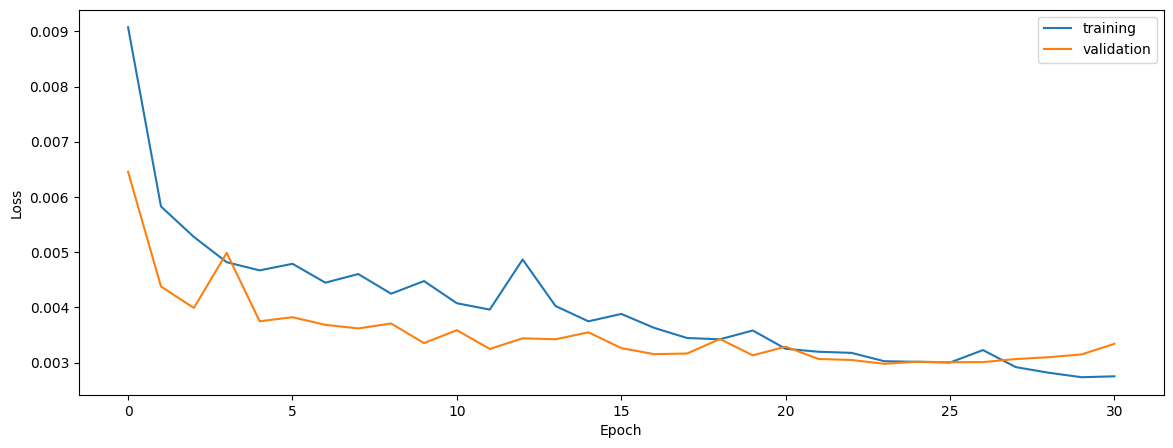

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8263109086018067
0.8107415855987962
0.8061349627279558


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8263109086018067
0.8107415855987962
0.8061349627279558


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8254301125752778
0.8093573961352588
0.80780689568037


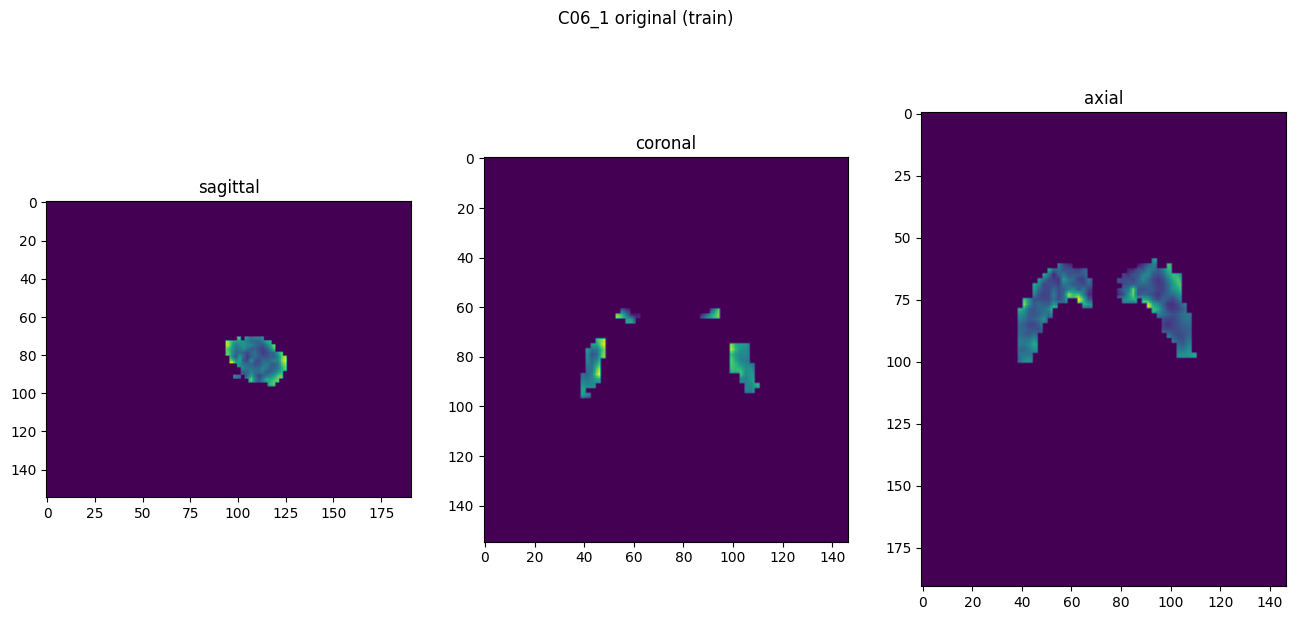

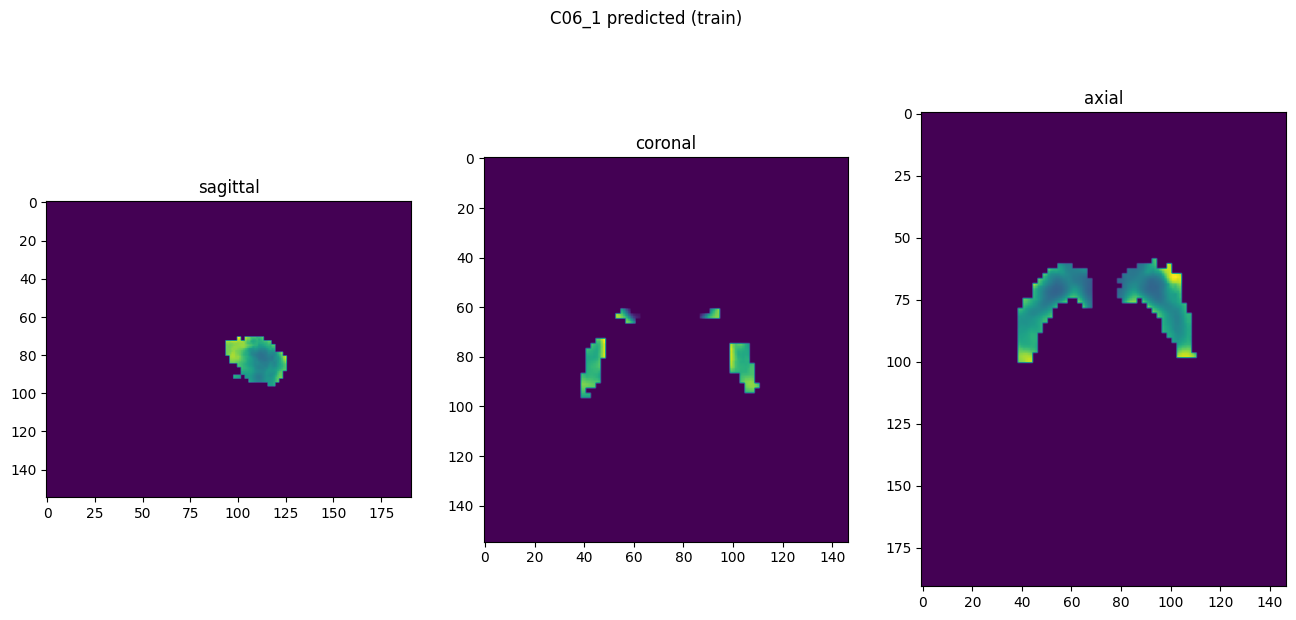

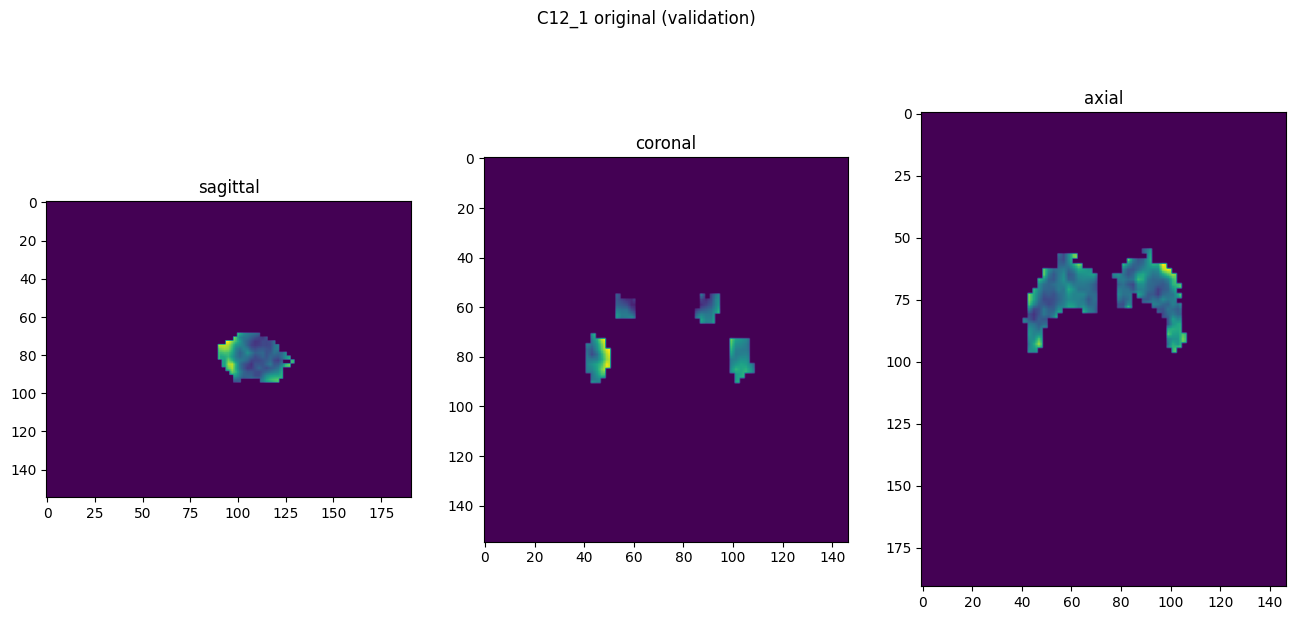

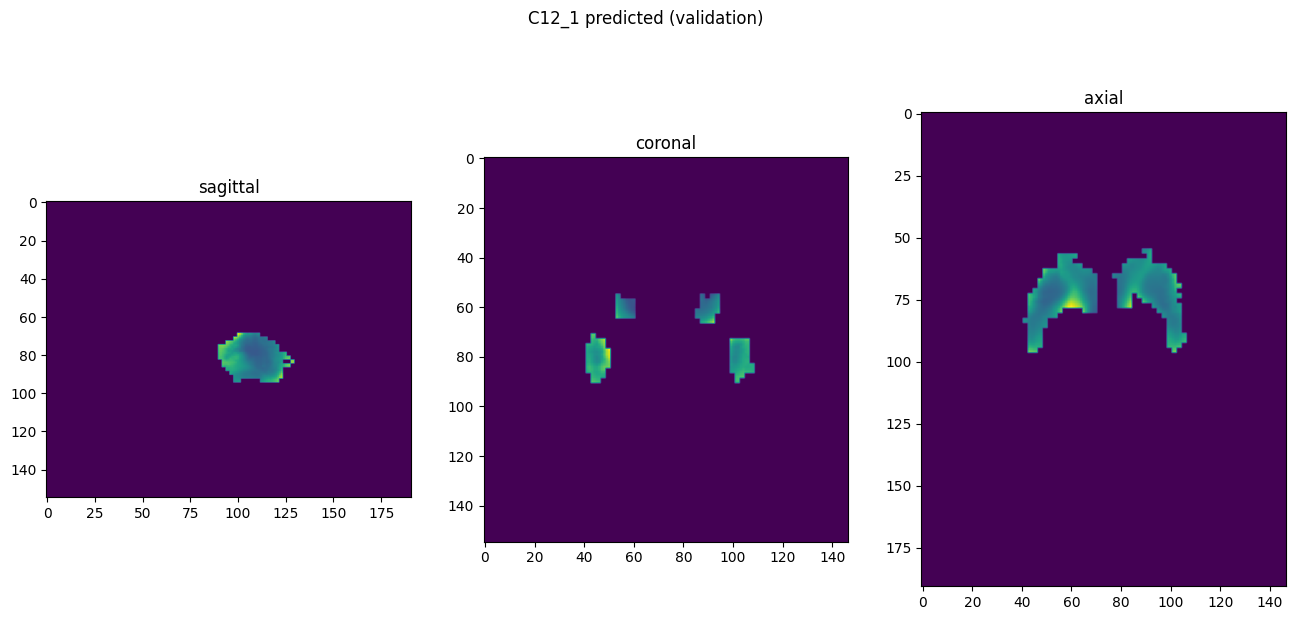

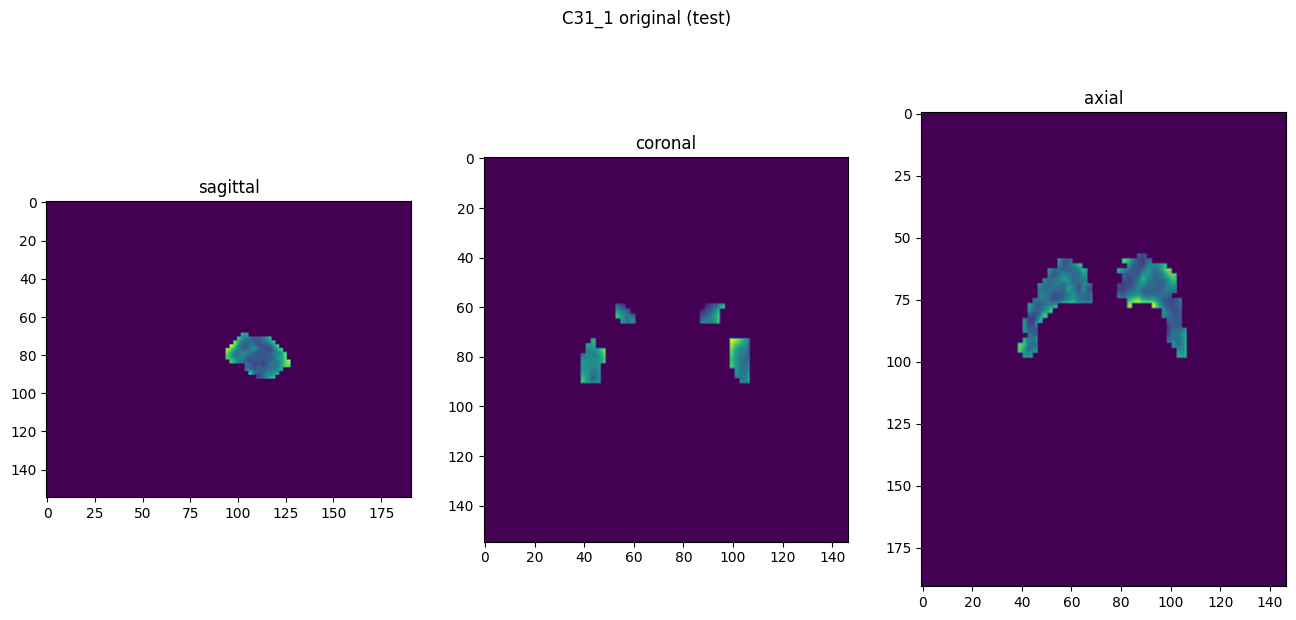

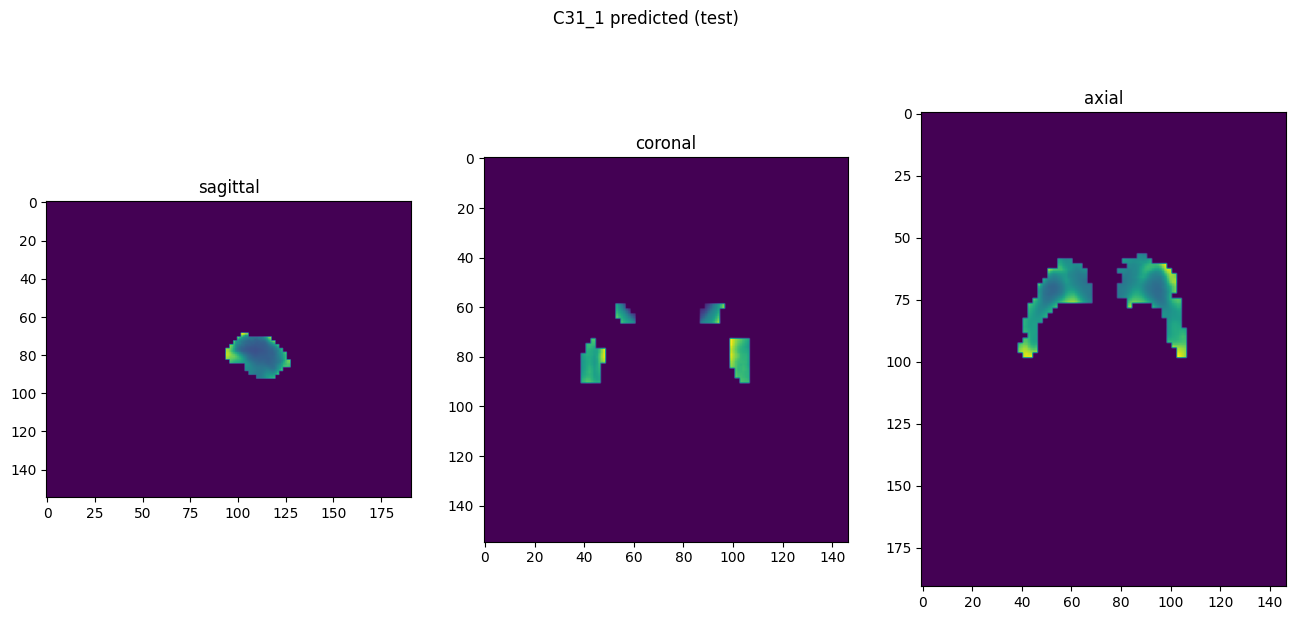

In [10]:
showResults(model, gen, threshold=None, background=False)